# Inference at high SNR

This notebook is to make sure anyone can do inference and produce the figures

In [1]:
import numpy as np
from astroNN.datasets import H5Loader
from astroNN.models import load_folder

# Load the dataset testing data
loader = H5Loader('_highsnr_test')
loader.load_combined = True  # load individual visits
loader.load_err = False
# load the correct entry with correct order from ApogeeBCNNcensored
loader.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                 'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x, y = loader.load()

# load RA, DEC, SNR entry
RA_visit = loader.load_entry('RA')
DEC_visit = loader.load_entry('DEC')
SNR_visit = loader.load_entry('SNR')

# Load model and do inference
bcnn = load_folder('astroNN_0605_run007')
bcnn.mc_num = 100
pred, pred_err = bcnn.test(x)

Using TensorFlow backend.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 109.69s in total


### Isochrones from http://stev.oapd.inaf.it/cgi-bin/cmd_3.0

**Configuration:**
- PARSEC v1.2S + COLIBRI PR16
- Gaia DR2 + Tycho2 + 2MASS (all Veggamags)
- NBC as described on Chen et al. (2014), based on PHOENIX BT-Settl for Teff<4000 K, and on ATLAS9 ODFNEW otherwise or on
- Aringer et al. (2009) (updated to include new spectra from Aringer et al. (2016)) 
- No dust
- Single isochrone of t = $5.0e-9$ yr, and $[Z/H]$ = $0.25$, $-0.25$, $-0.75$, $-1.75$

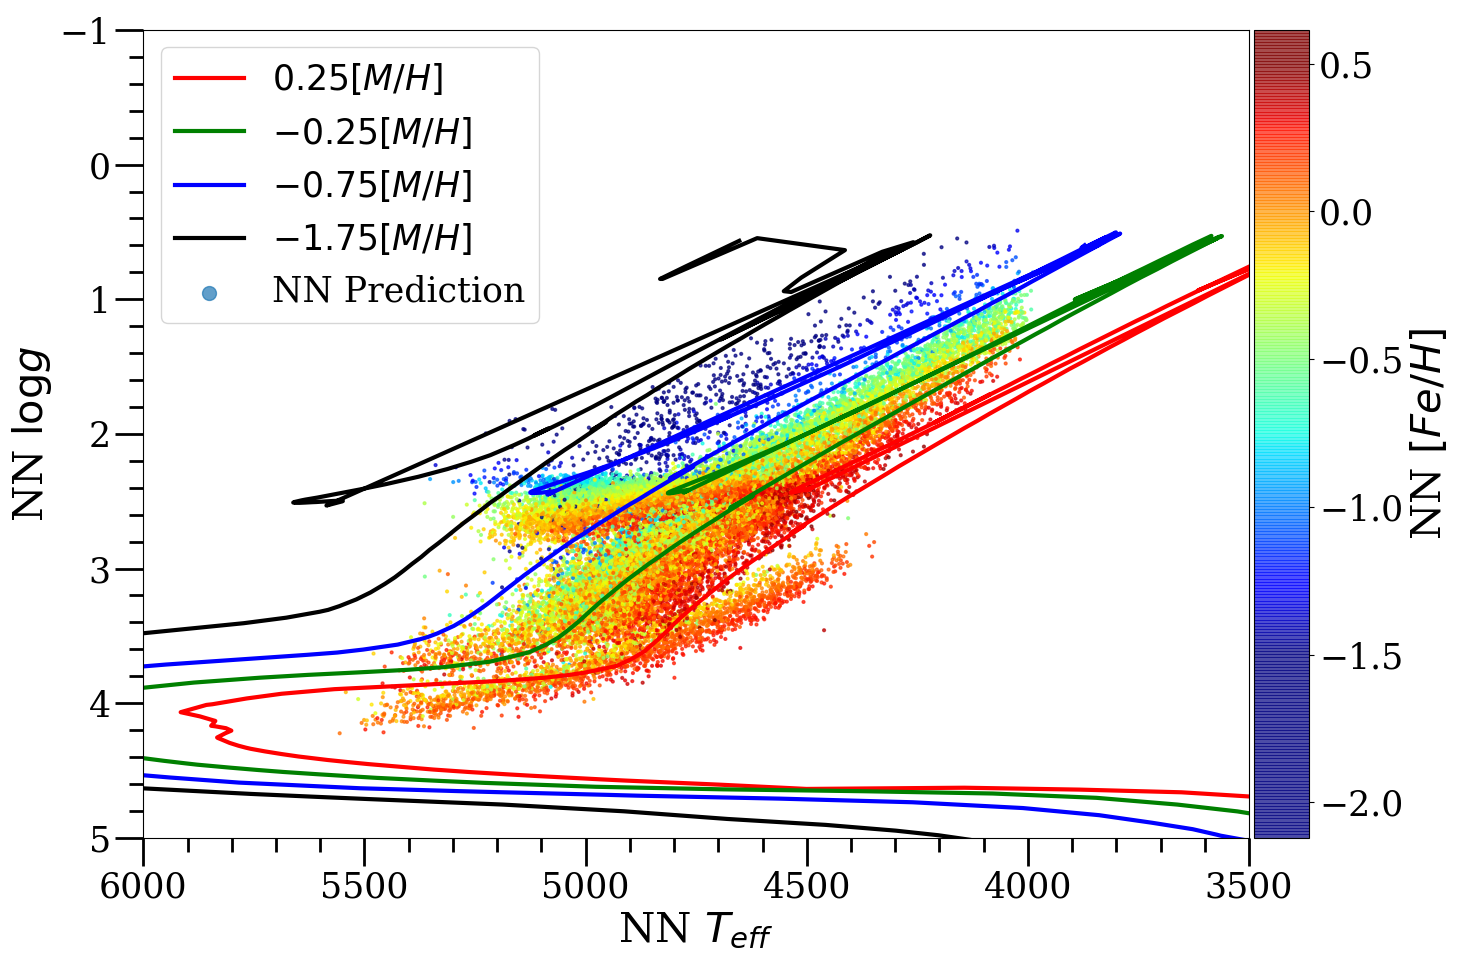

In [3]:
%matplotlib inline
import numpy as np
import pylab as plt
import astropy.io.ascii
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# load +0.25Z
data_p025 = astropy.io.ascii.read('isochrones\z_p025.dat')
teff_isochrone_p025 = 10 ** data_p025['col6']
logg_isochrone_p025 = data_p025['col7']
good_idx_p025 = [(logg_isochrone_p025 > 0.5) & (teff_isochrone_p025 < 6200)]

# load -0.25Z
data_n025 = astropy.io.ascii.read('isochrones\z_n025.dat')
teff_isochrone_n025 = 10 ** data_n025['col6']
logg_isochrone_n025 = data_n025['col7']
good_idx_n025 = [(logg_isochrone_n025 > 0.5) & (teff_isochrone_n025 < 6200)]

# load -0.75Z
data_n075 = astropy.io.ascii.read('isochrones\z_n075.dat')
teff_isochrone_n075 = 10 ** data_n075['col6']
logg_isochrone_n075 = data_n075['col7']
good_idx_n075 = [(logg_isochrone_n075 > 0.5) & (teff_isochrone_n075 < 6200)]

# load -1.75Z
data_n175 = astropy.io.ascii.read('isochrones\z_n175.dat')
teff_isochrone_n175 = 10 ** data_n175['col6']
logg_isochrone_n175 = data_n175['col7']
good_idx_n175 = [(logg_isochrone_n175 > 0.5) & (teff_isochrone_n175 < 6200)]

fig = plt.figure(figsize=(15,10), dpi=100)
ax = plt.gca()
plt.scatter(pred[:,0], pred[:,1], s=4., c=pred[:,19], label=f'NN Prediction', alpha=0.7, cmap='jet')
plt.plot(teff_isochrone_p025[good_idx_p025], logg_isochrone_p025[good_idx_p025], lw=3., c='r', label=r'$0.25 [M/H]$')
plt.plot(teff_isochrone_n025[good_idx_n025], logg_isochrone_n025[good_idx_n025], lw=3., c='g', label=r'$-0.25 [M/H]$')
plt.plot(teff_isochrone_n075[good_idx_n075], logg_isochrone_n075[good_idx_n075], lw=3., c='b', label=r'$-0.75 [M/H]$')
plt.plot(teff_isochrone_n175[good_idx_n175], logg_isochrone_n175[good_idx_n175], lw=3., c='k', label=r'$-1.75 [M/H]$')
plt.xlabel('NN ' +"$T_{eff}$", fontsize=30)
plt.ylabel('NN '+'$\log{g}$', fontsize=30)
plt.xlim((3500., 6000.))
plt.ylim((-1., 5.))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=2, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
#colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.set_clim(vmin=-1.5, vmax=0.5)
cbar.ax.tick_params(labelsize=25)
cbar.set_label("NN "+"$[Fe/H]$", size=30)
            
plt.tight_layout()
plt.savefig('logg_teff_fe_isochrones.png')
plt.show()

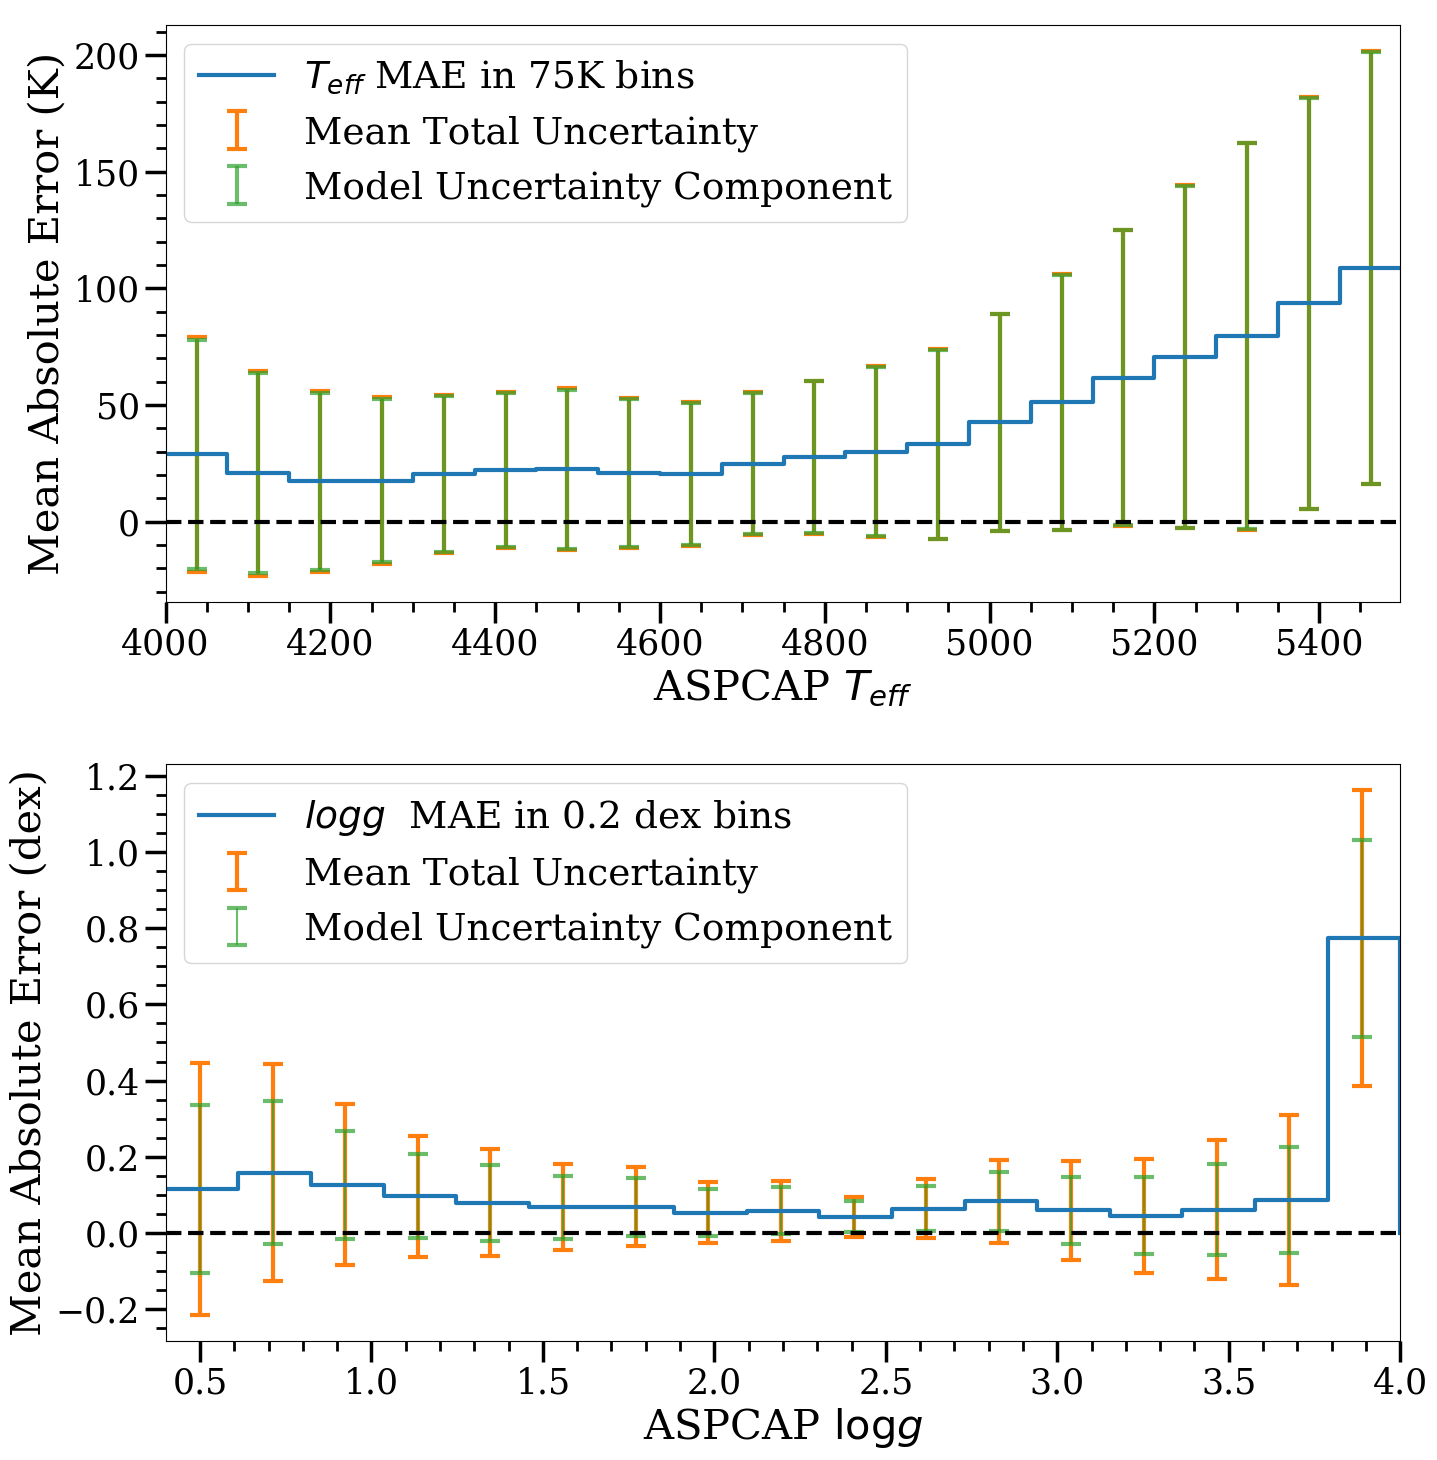

In [5]:
%matplotlib inline
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Teff
aspcap_idx = 0
number_bin = 20
low_teff = 4000.
high_teff = 5500.
mean_abs_diff_teff = []
mean_confidence_teff = []
mean_modelconfidence_teff = []
spaces_teff = np.linspace(low_teff, high_teff, number_bin+1)

# Binning

for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_teff[i+1])&(y[:,aspcap_idx]>spaces_teff[i])]
    mean_abs_diff_teff.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_teff.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_teff.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_teff.append(0.)
mean_confidence_teff.append(0.)
mean_modelconfidence_teff.append(0.)

# Log(g)
aspcap_idx = 1
number_bin = 17
low_logg = 0.4  # because min(logg) in the dataset is 0.42667553
high_logg = 4.0
mean_abs_diff_logg = []
mean_confidence_logg = []
mean_modelconfidence_logg = []
spaces_logg = np.linspace(low_logg, high_logg, number_bin+1)

# Binning
for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_logg[i+1])&(y[:,aspcap_idx]>spaces_logg[i])]
    mean_abs_diff_logg.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_logg.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_logg.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_logg.append(0.)
mean_confidence_logg.append(0.)
mean_modelconfidence_logg.append(0.)

# setup plots
f, ax = plt.subplots(2,figsize=(15,15), dpi=100)

ax[0].plot(spaces_teff, mean_abs_diff_teff, ls='steps-post', linewidth=3., label='$T_{eff}$' + ' MAE in 75K bins')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_confidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_modelconfidence_teff, linestyle='None', capsize=7, elinewidth=3., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[0].set_xlabel('ASPCAP ' +"$T_{eff}$", fontsize=30)
ax[0].set_ylabel('Mean Absolute Error (K)', fontsize=30)
ax[0].set_xlim((low_teff, high_teff-2))
ax[0].axhline(0, ls='--', c='k', lw=3.)
ax[0].legend(loc='best', fontsize=27)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[0].tick_params(width=2, length=7, which='minor')

ax[1].plot(spaces_logg, mean_abs_diff_logg, ls='steps-post', linewidth=3., label='$log{g}$' + '  MAE in 0.2 dex bins')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_confidence_logg, linestyle='None', capsize=7, elinewidth=3., capthick=3., label='Mean Total Uncertainty')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_modelconfidence_logg, linestyle='None', capsize=7, elinewidth=0., capthick=3., alpha=0.7, label='Model Uncertainty Component')
ax[1].set_xlabel('ASPCAP ' +"$\log{g}$", fontsize=30)
ax[1].set_ylabel('Mean Absolute Error (dex)', fontsize=30)
ax[1].set_xlim((low_logg, high_logg-0.001))
ax[1].axhline(0, ls='--', c='k', lw=3.)
ax[1].legend(loc='best', fontsize=27)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=25, width=2.5, length=15, which='major')
ax[1].tick_params(width=2, length=7, which='minor')

f.tight_layout()
# f.savefig('delta_teff_logg.png')

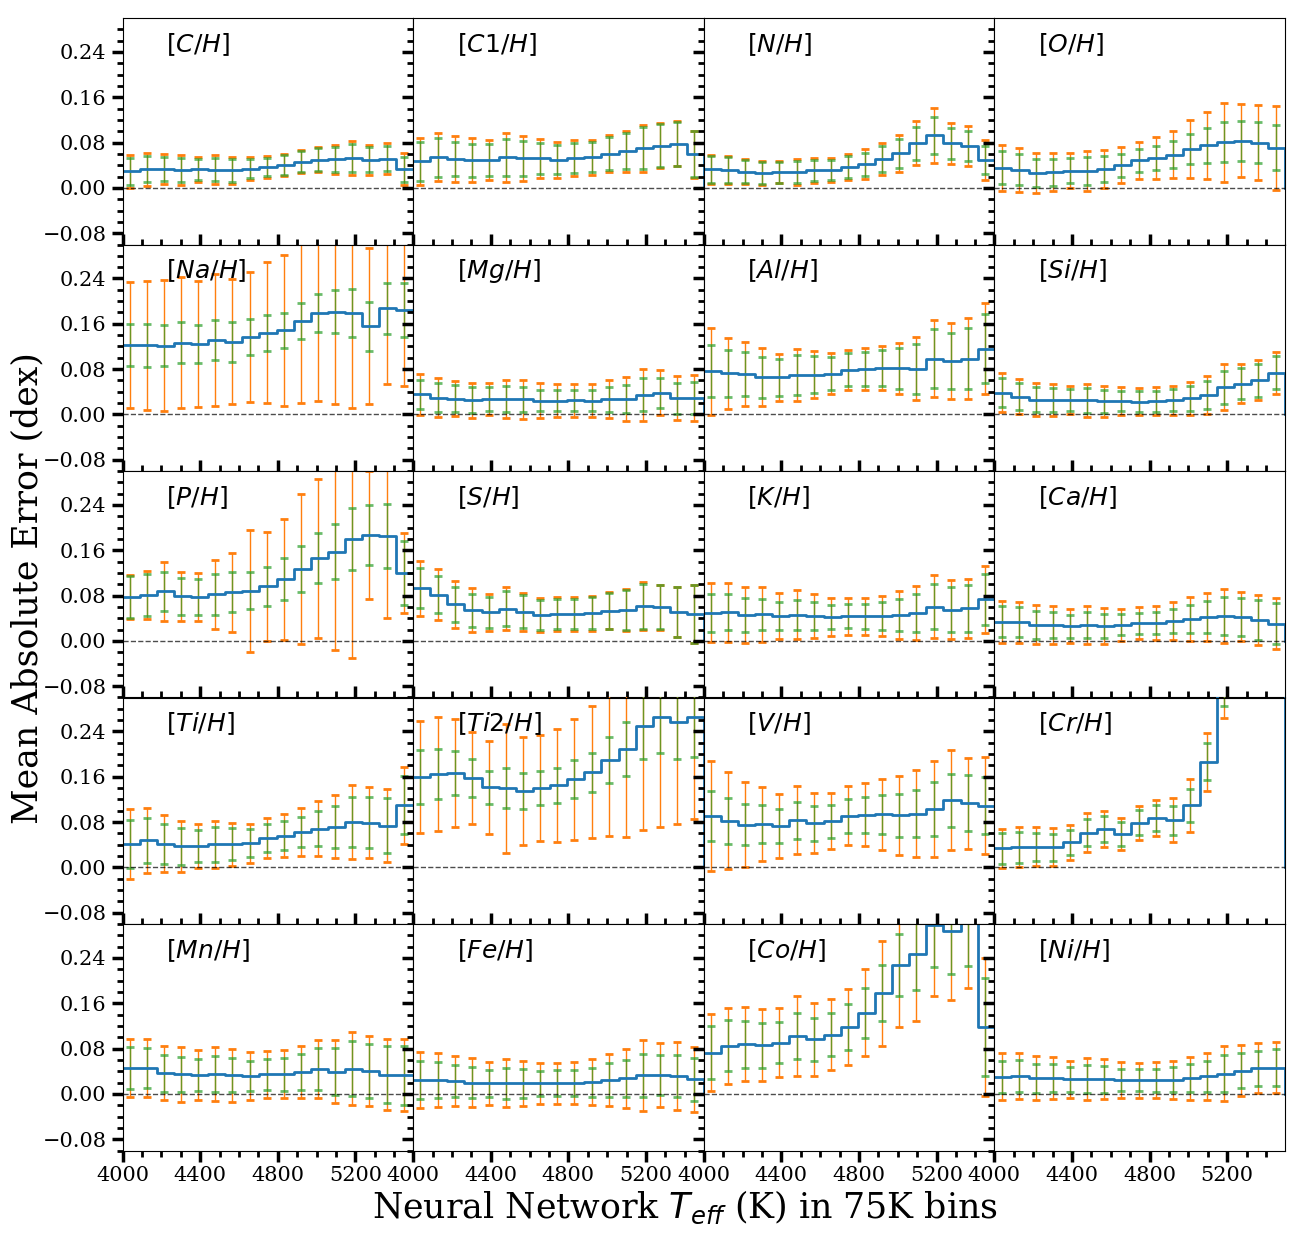

In [4]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from astroNN.nn.numpy import mean_absolute_error
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
aspcap_idx = 2
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_teff_x = np.linspace(low_teff, high_teff, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(400)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(pred[:,0]<spaces_teff_x[ii+1])&(pred[:,0]>spaces_teff_x[ii])]
            mean_abs_diff_x.append(mean_absolute_error(pred[:, aspcap_idx][idx], y[:,aspcap_idx][idx]))
            mean_confidence_x.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
            mean_modelconfidence_x.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_teff_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_teff, high_teff-2))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.15,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
f.text(0.5,0.08,'Neural Network ' + "$T_{eff}$" + " " + "(K) in 75K bins", fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Mean Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
# f.savefig('delta_xh_teff.png')

C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


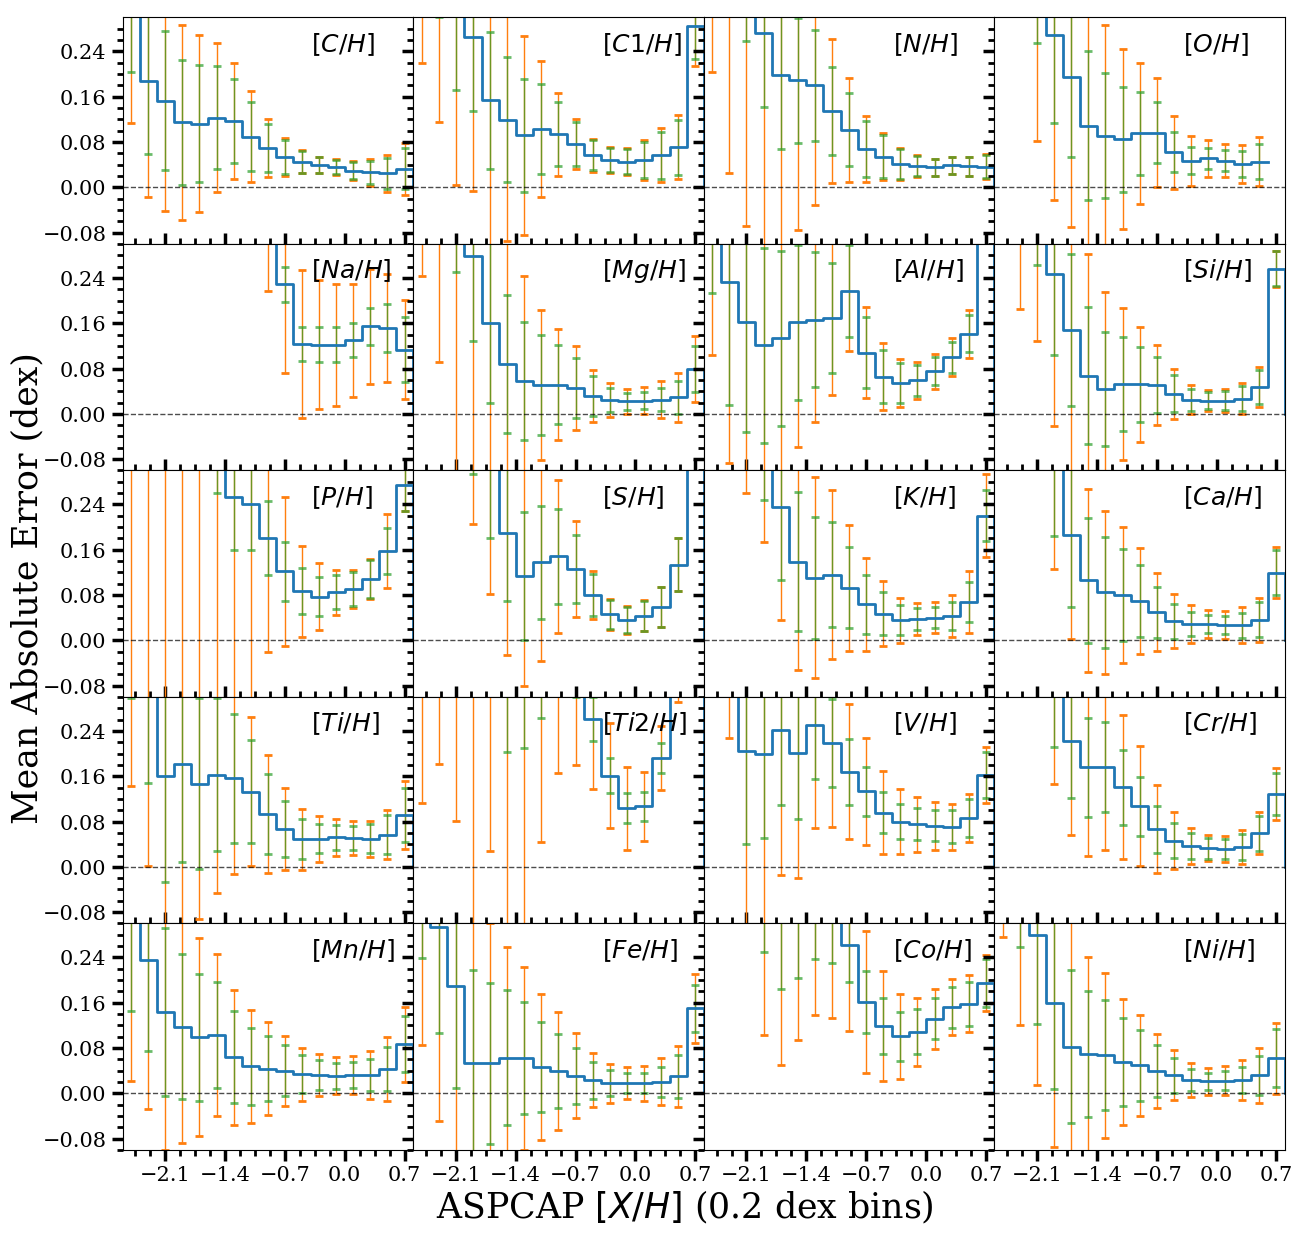

In [5]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_x = np.linspace(low_x, high_x, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(0.7)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(y[:,aspcap_idx]<spaces_x[ii+1])&(y[:,aspcap_idx]>spaces_x[ii])]
            mean_abs_diff_x.append(np.mean(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
            mean_confidence_x.append(np.mean(pred_err['total'][:, aspcap_idx][idx]))
            mean_modelconfidence_x.append(np.mean(pred_err['model'][:, aspcap_idx][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_x, high_x))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.65,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
        
f.text(0.5,0.08,"ASPCAP "+"$[X/H]$" + " (0.2 dex bins)",fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Mean Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
# f.savefig('compact_test.png')